**Lotka-Volterra equation**

Retyped by Theodoret Putra Agatho on 4 Aug. 2023

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/lotka.volterra.html

In [1]:
pip install deepxde

**Problem setup**

We will solve a Lotka-Volterra equation:

\begin{align}
        \frac{dr}{dt} = \frac{R}{U} (2Ur - 0.04U^2rp)
    \end{align}

\begin{align}
        \frac{dp}{dt} = \frac{R}{U} (0.02U^2rp - 1.06Up)
    \end{align}

with the initial condition

\begin{align}
        r(0) = \frac{100}{U}, p(0) = \frac{15}{U}
    \end{align}

and two user-specified parameters
\begin{align}
        U = 200, R = 20,
    \end{align}

the first of which approximates the upper bound of the range, and the second is the right bound of the domain. These two will be used for scaling.

The reference solution is generated using `integrate.solve_ivp()` from `scipy`.

**Implementation**

This description goes through the implementation of a solver for the above described Lotka-Volterra equation step-by-step.

Frist, the DeepXDE, numpy, matplotlib, and scipy packages are imported:

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining the approxximate upper bound of the range and the right bound of the domain. Later, we scale by these factors to obtain a graph between 0 and 1 when graphing population vs time.

In [3]:
ub = 200
rb = 20

We now define a time domain. We do this by using the built-in class `TimeDomain`:

In [4]:
geom = dde.geometry.TimeDomain(0.0, 1.0)

Next, we express the ODE system:

In [5]:
def ode_system(x, y):
  r = y[:, 0:1]
  p = y[:, 1:2]
  dr_t = dde.grad.jacobian(y, x, i=0)
  dp_t = dde.grad.jacobian(y, x, i=1)
  return [
      dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
      dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
  ]

The first argument to `ode_system` is the $t$-coordinate, represented by `x`. The second argument is a 2-dimensional vector, represented as `y`, which contains $r(t)$ and $p(t)$.

Now, we define the ODE problem as

In [6]:
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test = 3000)

Note that when solving this equation, we ant to have hard constraints on the initial conditions, so we define this later when creating the network rather than as part of the PDE.

We have 3000 training residual points inside the domain and 2 points on the boundary. We use 3000 points for testing the ODE residual. We now create the network:

In [7]:
layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

This is a neural network of depth 7 with 6 hidden layers of width 50. We use $tanh$ as the activation function. Since we expect to have periodic behavior in the Lotka-Volterra equation, we add a feature layer with $sin(kt)$. This forces the prediction to be periodic and therefore more accurate.

In [8]:
def input_transform(t):
  return tf.concat(
      (
          t,
          tf.sin(t),
          tf.sin(2 * t),
          tf.sin(3 * t),
          tf.sin(4 * t),
          tf.sin(5 * t),
          tf.sin(6 * t),
      ),
      axis=1,
  )

As mentioned earlier, we want the initial conditions $r(0) = \frac{100}{U}$ and $p(0) =  \frac{15}{U}$ to be hard constraints, so we transform the output:

In [9]:
def output_transform(t, y):
  y1 = y[:, 0:1]
  y2 = y[:, 1:2]

  return tf.concat(
      [y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1
  )

We add these layers:

In [10]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

Now that we have defined the neural network, we build a `Model`, choose the optimizer and learning rate, and train it for 50000 iterations:

In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.398389 s

'compile' took 3.170516 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.71e+02, 2.67e+01]    [1.71e+02, 2.68e+01]    []  
1000      [2.76e+00, 4.12e-01]    [2.64e+00, 4.05e-01]    []  
2000      [1.97e+00, 5.39e-01]    [1.87e+00, 5.27e-01]    []  
3000      [1.46e+00, 5.59e-01]    [1.37e+00, 5.43e-01]    []  
4000      [1.01e+00, 4.70e-01]    [9.44e-01, 4.54e-01]    []  
5000      [6.69e-01, 3.90e-01]    [6.26e-01, 3.75e-01]    []  
6000      [4.21e-01, 3.27e-01]    [3.94e-01, 3.14e-01]    []  
7000      [2.50e-01, 2.52e-01]    [2.35e-01, 2.42e-01]    []  
8000      [2.18e-01, 1.97e-01]    [2.12e-01, 1.89e-01]    []  
9000      [1.34e-01, 1.27e-01]    [1.32e-01, 1.23e-01]    []  
10000     [6.09e-02, 8.60e-02]    [6.07e-02, 8.40e-02]    []  
11000     [1.60e-01, 7.06e-02]    [1.60e-01, 6.91e-02]    []  
12000     [4.41e-02, 8.02e-02]    [4.41e-02, 7.96e-02]    []  
13000     [1.78e-01, 7.70e-02]    [1.78e

After training with Adam, we continue with L-BFGS to have an even smaller loss:

Compiling model...
'compile' took 0.836400 s

Training model...

Step      Train loss              Test loss               Test metric
50000     [8.32e-03, 9.35e-03]    [8.32e-03, 9.36e-03]    []  
51000     [1.67e-05, 2.37e-05]    [1.67e-05, 2.37e-05]        
51976     [5.30e-06, 8.01e-06]    [5.27e-06, 8.00e-06]    []  

Best model at step 51976:
  train loss: 1.33e-05
  test loss: 1.33e-05
  test metric: []

'train' took 229.676078 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


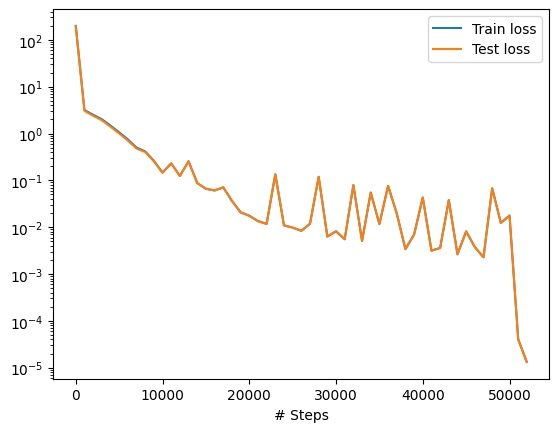

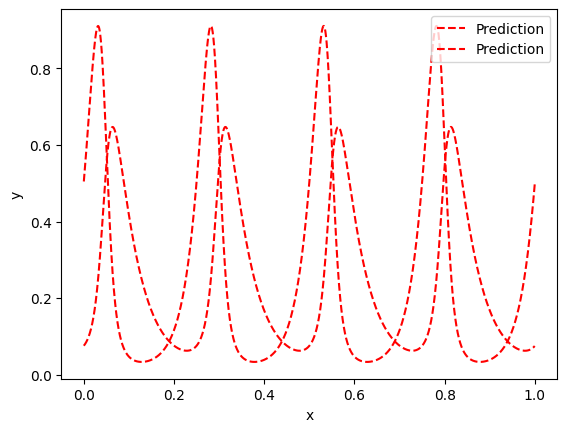

In [12]:
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

**Additional Visualisation**

Additional code to give visualisation of the results. Taken parts are from **Complete code** section.

In [13]:
def func(t, r):
  x, y = r
  dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
  dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
  return dx_t, dy_t

def gen_truedata():
  t = np.linspace(0, 1, 100)

  sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
  x_true, y_true = sol.y
  x_true = x_true.reshape(100, 1)
  y_true = y_true.reshape(100, 1)
  return x_true, y_true

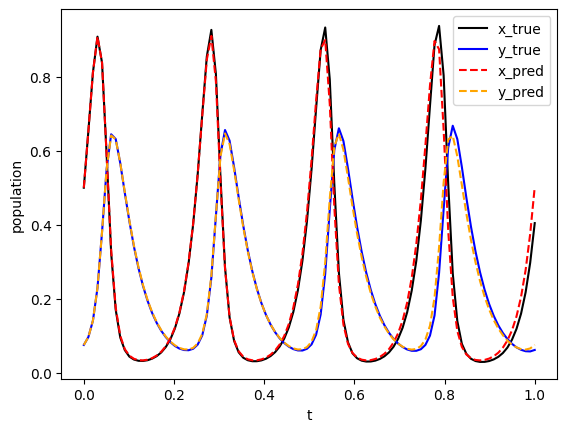

In [14]:
plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()